In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pwd

/home/stinal/Documents/BIASLYZE/repositories/biaslyze/notebooks


In [3]:
import sys
sys.path.append('/home/stinal/Documents/BIASLYZE/repositories/biaslyze/')

In [4]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Load and prepare data

In [5]:
df = pd.read_csv("../data/movie-reviews/movie.csv"); df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [6]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=10000, stop_words="english"), LogisticRegression())

In [7]:
clf.fit(df.text, df.label)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression())])

In [8]:
train_pred = clf.predict(df.text)
print(accuracy_score(df.label, train_pred))

0.920625


# Test concept detection

In [9]:
from biaslyze.concept_detectors import KeywordConceptDetector
from biaslyze.evaluators import LimeBiasEvaluator
from biaslyze.bias_detectors import LimeKeywordBiasDetector

/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
key_detect = KeywordConceptDetector()

In [11]:
detected_reviews = key_detect.detect(texts=df.text[:600])

2023-04-21 16:12:27.232 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 600 texts...
100%|████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 4226.74it/s]
2023-04-21 16:12:27.376 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 600 texts with protected concepts.


In [12]:
len(detected_reviews)

600

# Test LIME Bias Detection via Keywords

In [13]:
bias_detector = LimeKeywordBiasDetector(bias_evaluator=LimeBiasEvaluator(n_lime_samples=500), n_top_keywords=30, use_tokenizer=True)

In [14]:
detection_res = bias_detector.detect(texts=df.text.sample(1500), predict_func=clf.predict_proba)

2023-04-21 16:12:27.446 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 1500 texts...
100%|████████████████████████████████████████████████████████████████████████| 1500/1500 [00:34<00:00, 43.38it/s]
2023-04-21 16:13:02.026 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 1368 texts with protected concepts.
2023-04-21 16:13:02.027 | INFO     | biaslyze.evaluators:evaluate:44 - Started bias detection on 1368 samples...
100%|████████████████████████████████████████████████████████████████████████| 1368/1368 [06:06<00:00,  3.73it/s]


In [15]:
detection_res.summary()

Detected 742 samples with potential issues.
    Potentially problematic concepts detected: [('gender', 612), ('nationality', 133), ('gendered words', 64), ('religion', 14)]
    Based on keywords: [('his', 77), ('he', 68), ('they', 66), ('man', 65), ('their', 45), ('them', 44), ('guy', 42), ('her', 41), ('woman', 40), ('actor', 38), ('him', 35), ('women', 29), ('she', 24), ('male', 19), ('god', 18), ('girl', 18), ('daughter', 17), ('men', 17), ('female', 15), ('miss', 14)].


In [16]:
detection_res.details(group_by_concept=True)

Concept: gender
[{'reason': ['she'],
  'text': 'I resisted watching 15 Park Avenue despite of recommendations, '
          'discarding the movie as a clichéd topic of extreme emotional dramas '
          'and over-the-top acting.<br /><br />Once in a while, movies like 15 '
          'Park Avenue come by and sweep you off your feet.<br /><br />The '
          'movie grasps your attention pretty early on and there is no moment '
          'to rest after that. Aparna Sen has done a wonderful job of gluing '
          'the audience to every line of the movie. The impeccable character '
          'development, "just right" amount of emotions and an enigmatic end '
          'to match it all...<br /><br />I have a renewed respect for Konkana '
          'Sen Sharma, who convincingly plays the schizophrenic Mithi. She '
          'beats expectation yet again after Page-3 and Mr.& Mrs.Iyer. Prof. '
          "Anjali's role is very well developed and Shabana does full justice "
          'to t

In [17]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)

Loading BokehJS ...

In [18]:
pos_dashboard = detection_res.dashboard(use_position=True)
show(pos_dashboard)

## Try to cluster detected biases

In [40]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

In [41]:
# Prepare embeddings
docs = [sample.text for sample in detection_res.biased_samples]
y = [", ".join(sample.bias_concepts) for sample in detection_res.biased_samples]
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom')
# Train BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model).fit(docs, embeddings)

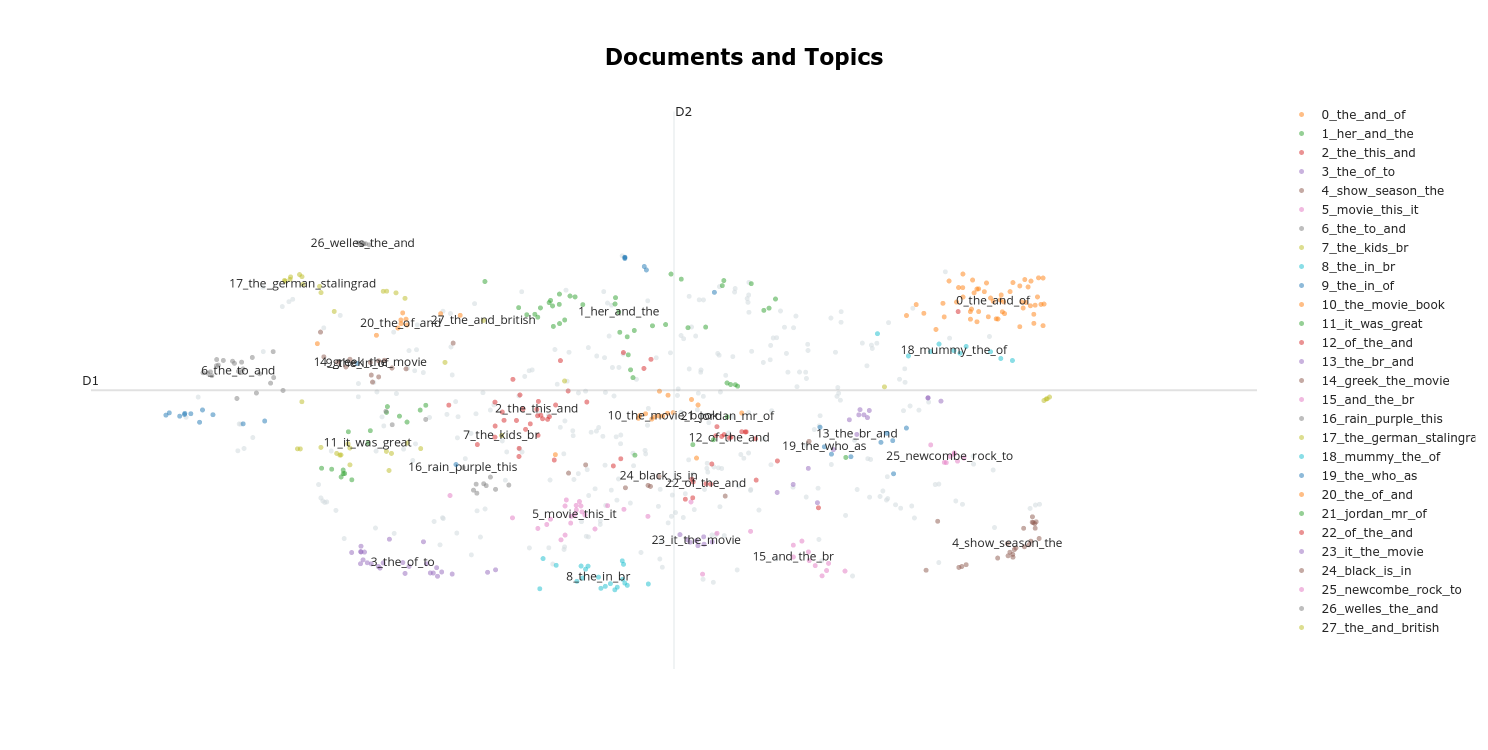

In [42]:
# Run the visualization with the original embeddings
topic_model.visualize_documents(docs, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [43]:
topic_model.topic_labels_

{-1: '-1_the_and_of_to',
 0: '0_the_and_of_horror',
 1: '1_her_and_the_of',
 2: '2_the_this_and_is',
 3: '3_the_of_to_and',
 4: '4_show_season_the_and',
 5: '5_movie_this_it_the',
 6: '6_the_to_and_is',
 7: '7_the_kids_br_and',
 8: '8_the_in_br_to',
 9: '9_the_in_of_you',
 10: '10_the_movie_book_and',
 11: '11_it_was_great_and',
 12: '12_of_the_and_to',
 13: '13_the_br_and_to',
 14: '14_greek_the_movie_and',
 15: '15_and_the_br_match',
 16: '16_rain_purple_this_film',
 17: '17_the_german_stalingrad_to',
 18: '18_mummy_the_of_to',
 19: '19_the_who_as_is',
 20: '20_the_of_and_is',
 21: '21_jordan_mr_of_his',
 22: '22_of_the_and_for',
 23: '23_it_the_movie_this',
 24: '24_black_is_in_midget',
 25: '25_newcombe_rock_to_of',
 26: '26_welles_the_and_of',
 27: '27_the_and_british_as'}

In [44]:
topic_model.topic_embeddings_

In [61]:
import yaml
from bokeh.themes import Theme
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, TextInput, HoverTool
from bokeh.palettes import Spectral5, Accent5, Category20_20
from bokeh.io import curdoc
from bokeh.layouts import column, row


def bkapp(doc):
    hover_tool = HoverTool(tooltips=[("Text", "@text"), ("Keywords", "@keywords")])
    p = figure(width=1200, height=800, tools=["pan","wheel_zoom","box_zoom","reset", hover_tool])

    bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
    concept2int = list(set(bias_concept))
    num_bias_concept = [concept2int.index(c) for c in bias_concept]
    bias_intensity = [500*np.abs(sample.score) for sample in detection_res.biased_samples]

    # configure
    df = pd.DataFrame(dict(
        text=[sample.text for sample in detection_res.biased_samples],
        keywords=[",".join(sample.bias_reasons) for sample in detection_res.biased_samples],
        x=reduced_embeddings[:,0],
        y=reduced_embeddings[:,1],
        color=[Category20_20[idx] for idx in num_bias_concept],
        bias_intensity=bias_intensity,
        bias_concept=bias_concept,
    ))
    source = ColumnDataSource(data=df)

    # add a circle renderer with a size, color, and alpha
    p.scatter(
        "x", "y",
        source=source,
        color="color",
        size="bias_intensity",
        alpha=0.3,
        legend_group="bias_concept",
    )

    p.legend.location = "top_left"
    #p.legend.click_policy="hide"

    # slider
    threshold = Slider(title="threshold", value=0.0, start=0.0, end=1.0, step=0.01, width=750)

    def update_data(attrname, old, new):
        # Get the current slider values
        t = threshold.value
        new_df = df.copy()
        new_df["bias_intensity"] = new_df.bias_intensity.apply(lambda x: x if x >= 50*t else 0.0)
        source.data = new_df

    threshold.on_change('value', update_data)


    doc.add_root(column(threshold, p, width=800))
    # show the results
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 800
                width: 1200
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)

In [56]:
bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
concept2int = list(set(bias_concept))

In [58]:
concept2int

['gendered words',
 'nationality',
 'religion,gender',
 'religion,gendered words',
 'nationality,gender',
 'nationality,gender,gendered words',
 'religion',
 'nationality,gendered words',
 'nationality,religion,gender',
 'gender',
 'gender,gendered words']